This notebook provides the plotting functions for Figure 5 a-g. These figures show the evaluation of a hierarchical clustering of chirp responses using sequential equality tests, and estimate the relative evidence for each of the first three nodes in the hierarchy.

In [1]:
%matplotlib inline

import GPy
import h5py
import json
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage, cut_tree
from scipy.interpolate import interp1d
from sklearn.isotonic import IsotonicRegression
import seaborn as sns

 /usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
from util.generate_contrasts import *
from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *
from util.plot_roi import *
from util.fill_bounds import *
from util.compute_cluster_freq import *

In [3]:
%config InlineBackend.figure_format = 'png'

sns.set_style('white')

title_fontsize = 13
label_fontsize = 10

fig_p = {
    'dpi': 600, 
    'bbox_inches': 'tight'
}

In [4]:
directories = json.load(open('directories.json'))

data_linear = load_hdf5(directories['data'] + 'SMP_BC4_lChirp.h5')

data_df = pd.read_csv(directories['data'] + 'SMP_BC4_lChirp.csv', index_col = 0)
data_df = data_df.groupby(['roi', 'frame']).mean().reset_index()

data_df = data_df.loc[data_df['roi'] != 15, :]

In [5]:
data = data_linear

triggers = data['Triggertimes']

stim_duration = np.mean(np.diff(triggers[::2]))
frame_duration = data['wDataCh0'].shape[1] * 0.002
new_tpnts = np.arange(0, stim_duration, frame_duration)

raw_traces = data['Traces0_raw']
raw_tpnts = data['Tracetimes0']

interp_f = interp1d(raw_tpnts[:, 0], raw_traces, axis = 0)
new_traces = np.dstack([interp_f(new_tpnts + start) for start in triggers[::2]])

traces = new_traces[:, :, ::2].mean(axis = 2)
traces = ((traces - traces.mean(axis = 0)) / traces.std(axis = 0))

n_tpnts, n_rois = traces.shape
tpnts = np.tile(new_tpnts[:, None], [1, n_rois])

In [6]:
i_roi = np.unique(data_df['roi'])
x_predict = np.linspace(data_df['x_t'].min(), data_df['x_t'].max(), 32 * 20)

iso_reg = IsotonicRegression()
iso_reg.fit(data_df['x_t'], data_df['x_t_warped'])
x_predict_warp = iso_reg.transform(x_predict)

posterior_mean = np.empty([x_predict.shape[0], i_roi.shape[0]])

for itx, roi in enumerate(i_roi):
    roi_bool = data_df['roi'] == roi
    x_t_warped = data_df.loc[roi_bool, 'x_t_warped'][:, None]
    y = zscore(data_df.loc[roi_bool, 'y'][:, None])
    
    m = GPy.models.SparseGPRegression(x_t_warped, y, num_inducing = 300, kernel = GPy.kern.RBF(1))
    m.optimize_restarts(1, max_iters = 25)
    posterior_mean[:, itx] = m.predict(x_predict_warp[:, None], include_likelihood = False)[0][:, 0]

Optimization restart 1/1, f = 2309.7144007440843
Optimization restart 1/1, f = 2684.046995391687
Optimization restart 1/1, f = 2909.0741153271074
Optimization restart 1/1, f = 2502.404948031766
Optimization restart 1/1, f = 2813.854541411437
Optimization restart 1/1, f = 2975.618638414472
Optimization restart 1/1, f = 2431.894183948527
Optimization restart 1/1, f = 2973.9715221998276
Optimization restart 1/1, f = 3467.456754672796
Optimization restart 1/1, f = 3016.4196079621424
Optimization restart 1/1, f = 2785.8339982111956
Optimization restart 1/1, f = 2575.7804286359965
Optimization restart 1/1, f = 3051.4199300548303
Optimization restart 1/1, f = 2917.7128274315396
Optimization restart 1/1, f = 3002.8697684119415
Optimization restart 1/1, f = 3277.7712694231723
Optimization restart 1/1, f = 3017.3320537022255
Optimization restart 1/1, f = 3365.3709899223354
Optimization restart 1/1, f = 3350.8038512356925
Optimization restart 1/1, f = 3051.624062620947
Optimization restart 1/1, f

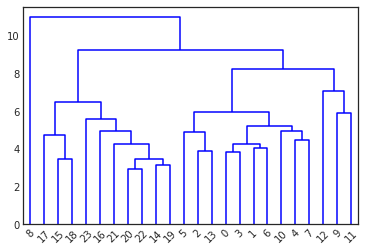

In [7]:
sns.set_style('white')

Z = linkage(posterior_mean.T, method = 'average')

D = dendrogram(Z, color_threshold = 0)

maxclust = 4

clusters = fcluster(Z, maxclust, criterion = 'maxclust')
clusters_order = clusters.argsort()
cluster_colours = sns.color_palette('hls', maxclust)

h_clusters = np.fliplr(cut_tree(Z)[:, -maxclust:]).T

posterior_sorted = posterior_mean[:, np.array(D['leaves'])]

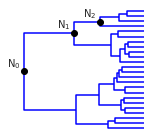

In [8]:
sns.set_style('white')

Z = linkage(posterior_sorted.T, method = 'ward')

fig, ax = plt.subplots(1)

D = dendrogram(Z, color_threshold = 0, ax = ax, orientation = 'left')

ax.set_xticklabels([]);

n_nodes = len(D['dcoord'])
for ind,(i, d) in enumerate(zip(D['icoord'], D['dcoord'])):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    
    if (ind > (n_nodes - 4)):
        node_idx = n_nodes - ind - 1
        plt.plot(y, x, 'ko')
        plt.annotate('N$_{' + str(node_idx) + '}$', (y, x), xytext=(-10, 15),
                     textcoords='offset points',
                     va='top', ha='center', fontsize = 10)

ax.tick_params(axis='y', which='major', labelsize = 6)
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, right = True, ax = ax)

fig.set_size_inches(2.25, 2.25)

plt.savefig(directories['figs'] + 'hierarchical/' + 'dendrogram.svg', **fig_p)

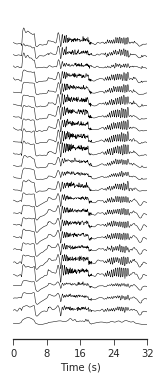

In [9]:
roi_colours = sns.color_palette('hls', traces.shape[1])
trace_offset = 2.5

sns.set_style('ticks')

fig, ax = plt.subplots(1)
# ax.set_title('ROI Mean Traces', fontsize = title_fontsize)

n_rois = len(D['dcoord']) + 1
for itx in range(n_rois):
    ax.plot(
        x_predict, 
        posterior_sorted[:, itx] + trace_offset * itx, 
        color = 'k',
        linewidth = 0.5
    )
#     ax.text(-0.5, itx * trace_offset, "R$_{" + str(itx) + "}$", fontsize = 10, ha = 'right')
    
fig.set_size_inches(2.4, 6)

ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
ax.set_yticklabels([]);
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.get_yaxis().set_visible(False)
sns.despine(left = True, ax = ax)

plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mean_traces.svg', **fig_p)

In [10]:
maxclust = 4
clusters = fcluster(Z, maxclust, criterion = 'maxclust')

clusters

array([4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1], dtype=int32)

1 vs 2
2 vs 3
3 vs 4

In [11]:
maxclust = 2
clusters = fcluster(Z, maxclust, criterion = 'maxclust')

n1_c1 = clusters == 1
n1_c1_df = data_df.loc[data_df.loc[:, 'roi'].isin(i_roi[n1_c1]), :]
n1_c1_x = n1_c1_df['x_t_warped'][:, None]
n1_c1_y = n1_c1_df['y'][:, None]

n1_c1_m = GPy.models.SparseGPRegression(n1_c1_x, n1_c1_y, num_inducing = 300, kernel = GPy.kern.RBF(1))
n1_c1_m.optimize_restarts(1, max_iters = 20)
n1_c1_mu, n1_c1_sig = n1_c1_m.predict(x_predict_warp[:, None], include_likelihood = False)

n1_c2 = clusters == 2
n1_c2_df = data_df.loc[data_df.loc[:, 'roi'].isin(i_roi[n1_c2]), :]
n1_c2_x = n1_c2_df['x_t_warped'][:, None]
n1_c2_y = n1_c2_df['y'][:, None]

n1_c2_m = GPy.models.SparseGPRegression(n1_c2_x, n1_c2_y, num_inducing = 300, kernel = GPy.kern.RBF(1))
n1_c2_m.optimize_restarts(1, max_iters = 20)
n1_c2_mu, n1_c2_sig = n1_c2_m.predict(x_predict_warp[:, None], include_likelihood = False)

Optimization restart 1/1, f = 30345.53634496607
Optimization restart 1/1, f = 23089.067849122068


In [12]:
maxclust = 3
clusters = fcluster(Z, maxclust, criterion = 'maxclust')

n2_c1 = clusters == 2
n2_c1_df = data_df.loc[data_df.loc[:, 'roi'].isin(i_roi[n2_c1]), :]
n2_c1_x = n2_c1_df['x_t_warped'][:, None]
n2_c1_y = n2_c1_df['y'][:, None]

n2_c1_m = GPy.models.SparseGPRegression(n2_c1_x, n2_c1_y, num_inducing = 300, kernel = GPy.kern.RBF(1))
n2_c1_m.optimize_restarts(1, max_iters = 20)
n2_c1_mu, n2_c1_sig = n2_c1_m.predict(x_predict_warp[:, None], include_likelihood = False)

n2_c2 = clusters == 3
n2_c2_df = data_df.loc[data_df.loc[:, 'roi'].isin(i_roi[n2_c2]), :]
n2_c2_x = n2_c2_df['x_t_warped'][:, None]
n2_c2_y = n2_c2_df['y'][:, None]

n2_c2_m = GPy.models.SparseGPRegression(n2_c2_x, n2_c2_y, num_inducing = 300, kernel = GPy.kern.RBF(1))
n2_c2_m.optimize_restarts(1, max_iters = 20)
n2_c2_mu, n2_c2_sig = n2_c2_m.predict(x_predict_warp[:, None], include_likelihood = False)

Optimization restart 1/1, f = 15499.541703404713
Optimization restart 1/1, f = 8093.5756711869135


In [13]:
maxclust = 4
clusters = fcluster(Z, maxclust, criterion = 'maxclust')

n3_c1 = clusters == 1
n3_c1_df = data_df.loc[data_df.loc[:, 'roi'].isin(i_roi[n3_c1]), :]
n3_c1_x = n1_c1_df['x_t_warped'][:, None]
n3_c1_y = n1_c1_df['y'][:, None]

n3_c1_m = GPy.models.SparseGPRegression(n3_c1_x, n3_c1_y, num_inducing = 300, kernel = GPy.kern.RBF(1))
n3_c1_m.optimize_restarts(1, max_iters = 20)
n3_c1_mu, n3_c1_sig = n3_c1_m.predict(x_predict_warp[:, None], include_likelihood = False)

n3_c2 = clusters == 2
n3_c2_df = data_df.loc[data_df.loc[:, 'roi'].isin(i_roi[n3_c2]), :]
n3_c2_x = n3_c2_df['x_t_warped'][:, None]
n3_c2_y = n3_c2_df['y'][:, None]

n3_c2_m = GPy.models.SparseGPRegression(n3_c2_x, n3_c2_y, num_inducing = 300, kernel = GPy.kern.RBF(1))
n3_c2_m.optimize_restarts(1, max_iters = 20)
n3_c2_mu, n3_c2_sig = n3_c2_m.predict(x_predict_warp[:, None], include_likelihood = False)

Optimization restart 1/1, f = 30044.851140320483
Optimization restart 1/1, f = 23715.53297773222


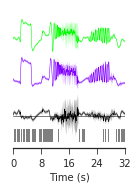

In [14]:
fig, ax = plt.subplots(1)

offset = 3

ax.plot(x_predict, n1_c1_mu + offset * 2, color = '#00ff00', linewidth = 0.5)
upper, lower = compute_bounds(n1_c1_mu, n1_c1_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0] + offset * 2, lower[:, 0] + offset * 2, facecolor = '#00ff00', alpha = 0.33)

ax.plot(x_predict, n1_c2_mu + offset, color = '#8000FF', linewidth = 0.5)
upper, lower = compute_bounds(n1_c2_mu, n1_c2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0] + offset, lower[:, 0] + offset, facecolor = '#8000FF', alpha = 0.33)

ax.plot(x_predict, n1_c1_mu - n1_c2_mu, color = 'k', linewidth = 0.5)
ax.plot(x_predict, np.zeros(x_predict.shape), color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(n1_c1_mu - n1_c2_mu, n1_c1_sig + n1_c2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)

diff_mask = (upper < 0) | (lower > 0)

y_min = - 1

ax.fill_between(
    x_predict, 
    np.ones(x_predict.shape) * 2 * y_min, 
    np.ones(x_predict.shape) * y_min, 
    where = diff_mask[:, 0], 
    facecolor = 'k', 
    alpha = 0.5
)

ax.set_xlim(-3, 12)
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)

fig.set_size_inches(2, 2.5)

plt.savefig(directories['figs'] + 'hierarchical/' + 'N0 Diff.svg', **fig_p)

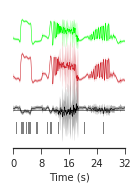

In [15]:
fig, ax = plt.subplots(1)

offset = 3

ax.plot(x_predict, n2_c1_mu + offset * 2, color = '#00ff00', linewidth = 0.5)
upper, lower = compute_bounds(n2_c1_mu, n2_c1_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0] + offset * 2, lower[:, 0] + offset * 2, facecolor = '#00ff00', alpha = 0.33)

ax.plot(x_predict, n2_c2_mu + offset, color = '#ce2029', linewidth = 0.5)
upper, lower = compute_bounds(n2_c2_mu, n2_c2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0] + offset, lower[:, 0] + offset, facecolor = '#ce2029', alpha = 0.33)

ax.plot(x_predict, n2_c1_mu - n2_c2_mu, color = 'k', linewidth = 0.5)
ax.plot(x_predict, np.zeros(x_predict.shape), color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(n2_c1_mu - n2_c2_mu, n2_c1_sig + n2_c2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)

diff_mask = (upper < 0) | (lower > 0)

y_min = - 1

ax.fill_between(
    x_predict, 
    np.ones(x_predict.shape) * 2 * y_min, 
    np.ones(x_predict.shape) * y_min, 
    where = diff_mask[:, 0], 
    facecolor = 'k', 
    alpha = 0.5
)

ax.set_xlim(-3, 12)
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)

fig.set_size_inches(2, 2.5)

plt.savefig(directories['figs'] + 'hierarchical/' + 'N1 Diff.svg', **fig_p)

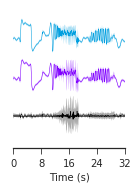

In [16]:
fig, ax = plt.subplots(1)

offset = 3

ax.plot(x_predict, n3_c1_mu + offset * 2, color = '#009FDF', linewidth = 0.5)
upper, lower = compute_bounds(n3_c1_mu, n3_c1_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0] + offset * 2, lower[:, 0] + offset * 2, facecolor = '#009FDF', alpha = 0.33)

ax.plot(x_predict, n3_c2_mu + offset, color = '#8000FF', linewidth = 0.5)
upper, lower = compute_bounds(n3_c2_mu, n3_c2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0] + offset, lower[:, 0] + offset, facecolor = '#8000FF', alpha = 0.33)

ax.plot(x_predict, n3_c1_mu - n3_c2_mu, color = 'k', linewidth = 0.5)
ax.plot(x_predict, np.zeros(x_predict.shape), color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(n3_c1_mu - n3_c2_mu, n3_c1_sig + n3_c2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)

diff_mask = (upper < 0) | (lower > 0)

y_min = - 1

ax.fill_between(
    x_predict, 
    np.ones(x_predict.shape) * 2 * y_min, 
    np.ones(x_predict.shape) * y_min, 
    where = diff_mask[:, 0], 
    facecolor = 'k', 
    alpha = 0.5
)

ax.set_xlim(-3, 12)
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)

fig.set_size_inches(2, 2.5)

plt.savefig(directories['figs'] + 'hierarchical/' + 'N2 Diff.svg', **fig_p)

In [17]:
from scipy.ndimage import label

n_sigma = np.linspace(0, 10, 100)

n_blob_n1 = np.zeros(n_sigma.shape[0])
n_blob_n2 = np.zeros(n_sigma.shape[0])
n_blob_n3 = np.zeros(n_sigma.shape[0])

for itx, sigma in enumerate(n_sigma):
    # N1
    upper, lower = compute_bounds(n1_c1_mu - n1_c2_mu, n1_c1_sig + n1_c2_sig, n_sigma = sigma)
    ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_n1[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()
    
    # N2
    upper, lower = compute_bounds(n2_c1_mu - n2_c2_mu, n2_c1_sig + n2_c2_sig, n_sigma = sigma)
    ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_n2[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()
    
    # N3
    upper, lower = compute_bounds(n3_c1_mu - n3_c2_mu, n3_c1_sig + n3_c2_sig, n_sigma = sigma)
    ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_n3[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

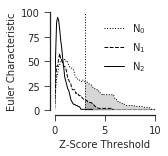

In [27]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_n1, linestyle = ':', label = 'N$_{0}$', linewidth = 1, color = 'k')
ax.plot(n_sigma, n_blob_n2, linestyle = '--', label = 'N$_{1}$', linewidth = 1, color = 'k')
ax.plot(n_sigma, n_blob_n3, linestyle = '-', label = 'N$_{2}$', linewidth = 1, color = 'k')
ax.plot(np.ones(100) * 3, np.arange(100), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_n1[sigma_mask],
    facecolor = 'k', 
    alpha = 0.16,
    clip_on = False
)

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_n2[sigma_mask],
    facecolor = 'k', 
    alpha = 0.16,
    clip_on = False
)

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_n3[sigma_mask],
    facecolor = 'k', 
    alpha = 0.16,
    clip_on = False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 100)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.legend()

sns.despine(ax = ax, offset = 5)

fig.set_size_inches(1.8, 1.8)

plt.savefig(directories['figs'] + 'hierarchical/' + 'zscore_vs_ec.svg', dpi = 300)

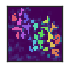

In [28]:
sns.set_style('white')

plot_roi(data_linear)

plt.gcf().set_size_inches(1, 1)

plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mask_all.svg', **fig_p)

In [29]:
scale_p = {
    'frameon': False,
    'location': 3,
    'color': 'w',
    'font_properties': {'size': 8},
    'length_fraction': 0.33,
    'height_fraction': 0.025,
    'sep': 1,
    'scale_loc': 'top',
    'label_loc': 'bottom'
}


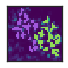

In [30]:
ROIs = data_linear['ROIs']
CLUSTERs = np.ones(ROIs.shape)

maxclust = 4
clusters = fcluster(Z, maxclust, criterion = 'maxclust')
clusters[clusters == 2] = 1
clusters[clusters == 4] = 3

for roi, cluster in zip(np.unique(ROIs), clusters):
    CLUSTERs[ROIs == roi] = -cluster

data_cluster = {}
data_cluster.update(data_linear)
data_cluster['ROIs'] = CLUSTERs

fig, ax = plt.subplots(1)

data = data_cluster
mean_image = data['wDataCh0'].mean(axis = -1)
roi_image = data['ROIs']

i_rois = [-4., -3., -2., -1.]
n_rois = len(i_rois)

roi_rgba = np.zeros(list(roi_image.shape) + [4,])
roi_rgba[roi_image != 1, :] = 1
roi_colours = sns.color_palette('hls', 4)

for itx, roi in enumerate(i_rois):
    roi_rgba[roi_image == roi, :] = list(roi_colours[itx]) + [1,]

imshow_p = {
    'origin': 'lower',
    'interpolation': 'nearest'
}

ax.imshow(mean_image, cmap = 'viridis',  **imshow_p)
ax.imshow(roi_rgba, **imshow_p)

ax.grid(False)
ax.set_xticklabels([]);
ax.set_yticklabels([]);

fig.set_size_inches(1, 1)

plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mask_n1.svg', **fig_p)

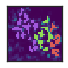

In [32]:
ROIs = data_linear['ROIs']
CLUSTERs = np.ones(ROIs.shape)

maxclust = 4
clusters = fcluster(Z, maxclust, criterion = 'maxclust')
clusters[clusters == 2] = 1

for roi, cluster in zip(np.unique(ROIs), clusters):
    CLUSTERs[ROIs == roi] = -cluster

data_cluster = {}
data_cluster.update(data_linear)
data_cluster['ROIs'] = CLUSTERs

fig, ax = plt.subplots(1)

data = data_cluster
mean_image = data['wDataCh0'].mean(axis = -1)
roi_image = data['ROIs']

roi_rgba = np.zeros(list(roi_image.shape) + [4,])
roi_rgba[roi_image != 1, :] = 1
roi_colours = sns.color_palette('hls', 4)

for itx, roi in enumerate(i_rois):
    roi_rgba[roi_image == roi, :] = list(roi_colours[itx]) + [1,]

imshow_p = {
    'origin': 'lower',
    'interpolation': 'nearest'
}

if not ax:
    fig, ax = plt.subplots(1)

ax.imshow(mean_image, cmap = 'viridis',  **imshow_p)
ax.imshow(roi_rgba, **imshow_p)

ax.grid(False)
ax.set_xticklabels([]);
ax.set_yticklabels([]);

fig.set_size_inches(1, 1)

plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mask_n2.svg', **fig_p)

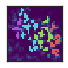

In [33]:
ROIs = data_linear['ROIs']
CLUSTERs = np.ones(ROIs.shape)

maxclust = 4
clusters = fcluster(Z, maxclust, criterion = 'maxclust')

for roi, cluster in zip(np.unique(ROIs), clusters):
    CLUSTERs[ROIs == roi] = -cluster

data_cluster = {}
data_cluster.update(data_linear)
data_cluster['ROIs'] = CLUSTERs

fig, ax = plt.subplots(1)

data = data_cluster
mean_image = data['wDataCh0'].mean(axis = -1)
roi_image = data['ROIs']

roi_rgba = np.zeros(list(roi_image.shape) + [4,])
roi_rgba[roi_image != 1, :] = 1
roi_colours = sns.color_palette('hls', 4)

for itx, roi in enumerate(i_rois):
    roi_rgba[roi_image == roi, :] = list(roi_colours[itx]) + [1,]

imshow_p = {
    'origin': 'lower',
    'interpolation': 'nearest'
}

ax.imshow(mean_image, cmap = 'viridis',  **imshow_p)
ax.imshow(roi_rgba, **imshow_p)

ax.grid(False)
ax.set_xticklabels([]);
ax.set_yticklabels([]);

fig.set_size_inches(1, 1)

plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mask_n3.svg', **fig_p)

In [34]:
all_traces = data_linear['Traces0_raw'][:, np.arange(25) != 14]

all_traces -= all_traces.mean(axis = 0)
all_traces /= all_traces.std(axis = 0)

n1_c1_traces = all_traces[:, n1_c1]
n1_c2_traces = all_traces[:, n1_c2]

n2_c1_traces = all_traces[:, n2_c1]
n2_c2_traces = all_traces[:, n2_c2]

n3_c1_traces = all_traces[:, n3_c1]
n3_c2_traces = all_traces[:, n3_c2]

n_sigma = np.linspace(0, 20, 500)

In [35]:
def compute_diff(trace_a, trace_b, n_sigma):

    n_blob_inner = np.zeros(n_sigma.shape[0])
    
    trace_a_mean = trace_a.mean(axis = 1)
    trace_a_std = trace_a.std(axis = 1)
    
    trace_b_mean = trace_b.mean(axis = 1)
    trace_b_std = trace_b.std(axis = 1)
    
    for itx, sigma in enumerate(n_sigma):
        # Compute EC
        upper, lower = compute_bounds(trace_a_mean - trace_b_mean, trace_a_std + trace_b_std, n_sigma = sigma)

        diff_mask = (upper < 0) | (lower > 0)

        n_blob_inner[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()
        
    return n_blob_inner

In [36]:
n_blob_n1_c = compute_diff(n1_c1_traces, n1_c2_traces, n_sigma)
n_blob_n2_c = compute_diff(n2_c1_traces, n2_c2_traces, n_sigma)
n_blob_n3_c = compute_diff(n3_c1_traces, n3_c2_traces, n_sigma)

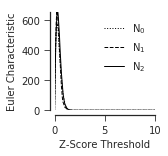

In [37]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_n1_c, linestyle = ':', label = 'N$_{0}$', linewidth = 1, color = 'k')
ax.plot(n_sigma, n_blob_n2_c, linestyle = '--', label = 'N$_{1}$', linewidth = 1, color = 'k')
ax.plot(n_sigma, n_blob_n3_c, linestyle = '-', label = 'N$_{2}$', linewidth = 1, color = 'k')

ax.set_xlim(0, 10)
ax.set_ylim(0, 650)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.legend()

sns.despine(ax = ax, offset = 5)

fig.set_size_inches(1.8, 1.8)

plt.savefig(directories['figs'] + 'hierarchical/' + 'zscore_vs_ec_classical.svg', dpi = 300)